
### Data Preparation  and Data Understanding


*   Making correction 
*   Reformatting
*   Combining Dataset

In [3]:
%reload_ext autoreload
%autoreload 2

In [4]:
# !pip install vadersentiment
# import nltk
# nltk.download('stopwords')
# nltk.download('wordnet')
# !pip install pyLDAvis

In [22]:
import os, sys
import re
import json
import glob
import datetime
from collections import Counter
import numpy as np

import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from wordcloud import WordCloud

import string
from wordcloud import STOPWORDS,WordCloud

import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
import gensim
from gensim.models import CoherenceModel
from gensim import corpora
import pandas as pd
from pprint import pprint
import string
import os
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer

In [5]:
# Add parent directory to path to import modules from src
rpath = os.path.abspath('..')
if rpath not in sys.path:
    sys.path.insert(0, rpath)

from src.loader import SlackDataLoader
import src.utils as utils

In [6]:
data_path  = '../data/'
DataLoader_obj = SlackDataLoader(path='../data/')

In [7]:
mesage_df = pd.DataFrame(columns = ['msg_type', 'msg_content', 'sender_name', 'msg_sent_time', 'msg_dist_type','time_thread_start', 'reply_count', 'reply_users_count', 'reply_users', 'tm_thread_end'])

for channel in DataLoader_obj.get_channels():
    channel_name = channel['name']
    mp_data = utils.slack_parser(f"{data_path}{channel_name}/")
    
    mesage_df = pd.concat([mesage_df, mp_data])
    


In [8]:
mesage_df.head()

,msg_type,msg_content,sender_name,msg_sent_time,msg_dist_type,time_thread_start,reply_count,reply_users_count,reply_users,tm_thread_end,channel
0,message,"A decent fellow, big ups brother",Travis Butler,1664960833.241189,text,1664954598.185699,0,0,0,0,
1,message,*Community Building Session REMINDER!*:timer_c...,Vanessa Norman,1664970601.066509,text,0,0,0,0,0,
2,message,when will we kahoot again:smirk:,Joshua Rhodes,1664970669.636589,text,1664970669.636589,2,2,"U03V1AM5TFA,U03U1FNPEUX",1664970735.145469,
3,message,"soon very soon, you miss it hahahah",Vanessa Norman,1664970705.135159,text,1664970669.636589,0,0,0,0,
4,message,yess,Joshua Rhodes,1664970735.145469,text,1664970669.636589,0,0,0,0,


In [9]:
mesage_df.columns

Index(['msg_type', 'msg_content', 'sender_name', 'msg_sent_time',
       'msg_dist_type', 'time_thread_start', 'reply_count',
       'reply_users_count', 'reply_users', 'tm_thread_end', 'channel'],
      dtype='object')

In [10]:
# check how many values each channel has
mesage_df.channel.value_counts()

channel
    17748
Name: count, dtype: int64

In [11]:
# list of columns, their non-null objects and data type of columns
mesage_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17748 entries, 0 to 1
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   msg_type           17748 non-null  object
 1   msg_content        17748 non-null  object
 2   sender_name        17748 non-null  object
 3   msg_sent_time      17748 non-null  object
 4   msg_dist_type      17748 non-null  object
 5   time_thread_start  17748 non-null  object
 6   reply_count        17748 non-null  object
 7   reply_users_count  17748 non-null  object
 8   reply_users        17748 non-null  object
 9   tm_thread_end      17748 non-null  object
 10  channel            17748 non-null  object
dtypes: object(11)
memory usage: 1.6+ MB


In [12]:
#check if there are any null values in the dataset 
mesage_df.isna().mean().round(4) *100

msg_type             0.0
msg_content          0.0
sender_name          0.0
msg_sent_time        0.0
msg_dist_type        0.0
time_thread_start    0.0
reply_count          0.0
reply_users_count    0.0
reply_users          0.0
tm_thread_end        0.0
channel              0.0
dtype: float64

<Axes: xlabel='channel'>

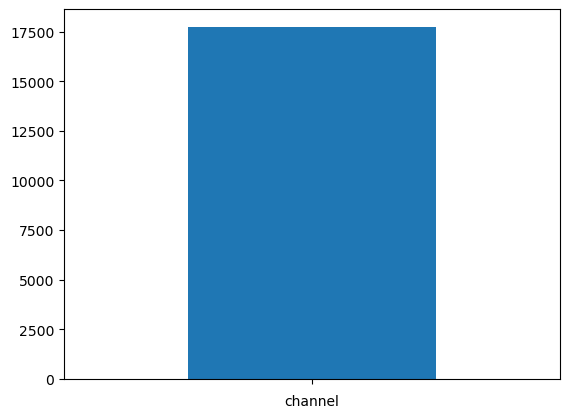

In [13]:
# To plot Top 20 Hashtags
mesage_df['channel'].value_counts().plot(kind='bar')

<Axes: xlabel='reply_count'>

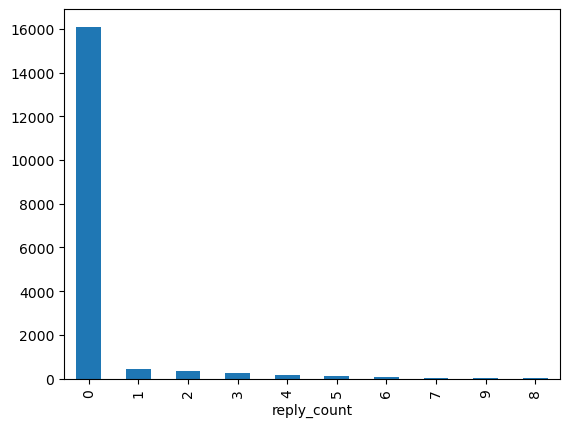

In [14]:
# To plot Top 20 Hashtags
mesage_df['reply_count'].value_counts()[:10].plot(kind='bar')

In [15]:
#convet the time 
mesage_df['msg_sent_time'] = utils.convert_2_timestamp('msg_sent_time', mesage_df)
mesage_df['time_thread_start'] = utils.convert_2_timestamp('time_thread_start', mesage_df)
mesage_df['tm_thread_end'] = utils.convert_2_timestamp('tm_thread_end', mesage_df)

In [16]:
mesage_df

,msg_type,msg_content,sender_name,msg_sent_time,msg_dist_type,time_thread_start,reply_count,reply_users_count,reply_users,tm_thread_end,channel
0,message,"A decent fellow, big ups brother",Travis Butler,2022-10-05 12:07:13,text,2022-10-05 10:23:18,0,0,0,0,
1,message,*Community Building Session REMINDER!*:timer_c...,Vanessa Norman,2022-10-05 14:50:01,text,0,0,0,0,0,
2,message,when will we kahoot again:smirk:,Joshua Rhodes,2022-10-05 14:51:09,text,2022-10-05 14:51:09,2,2,"U03V1AM5TFA,U03U1FNPEUX",2022-10-05 14:52:15,
3,message,"soon very soon, you miss it hahahah",Vanessa Norman,2022-10-05 14:51:45,text,2022-10-05 14:51:09,0,0,0,0,
4,message,yess,Joshua Rhodes,2022-10-05 14:52:15,text,2022-10-05 14:51:09,0,0,0,0,
...,...,...,...,...,...,...,...,...,...,...,...
58,message,How are we going to do the submission today? E...,Brenda Hernandez,2022-11-07 17:31:58,text,2022-11-07 17:31:58,1,1,U03TEPYRM2P,2022-11-07 17:36:42,
59,message,Thank you,Garrett Bell,2022-11-07 17:36:42,text,2022-11-07 17:31:58,0,0,0,0,
60,message,"the document is not uploaded yet, and what is ...",Cristian Wilson,2022-11-07 18:11:15,text,2022-11-07 18:11:15,2,1,U03UP7V9Q57,2022-11-07 18:36:22,
0,message,How can I get the trainees that opted-in a giv...,Katie Dickerson,2022-11-12 19:53:43,text,0,0,0,0,0,


### Text Preprocessing

In [20]:
class PrepareData:
      def __init__(self,df):
        self.msg_df =df
        
    
      def preprocess_data(self):
      
        #text Preprocessing
        self.msg_df['msg_content'] = self.msg_df['msg_content'].astype(str)
        self.msg_df['msg_content'] = self.msg_df['msg_content'].apply(lambda x: x.lower())
        self.msg_df['msg_content']= self.msg_df['msg_content'].apply(lambda x: x.translate(str.maketrans(' ', ' ', string.punctuation)))
        self.msg_df['msg_content']= self.msg_df['msg_content'].str.replace('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' ')
        stop = stopwords.words('english')
        self.msg_df['msg_content'] = self.msg_df['msg_content'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
     
        # Remove emojis
        emoji_pattern = re.compile("["
                                   u"\U0001F600-\U0001F64F"  # emoticons
                                   u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                                   u"\U0001F680-\U0001F6FF"  # transport & map symbols
                                   u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                                   u"\U00002500-\U00002BEF"  # chinese char
                                   u"\U00002702-\U000027B0"
                                   u"\U00002702-\U000027B0"
                                   u"\U000024C2-\U0001F251"
                                   u"\U0001f926-\U0001f937"
                                   u"\U00010000-\U0010ffff"
                                   u"\u2640-\u2642"
                                   u"\u2600-\u2B55"
                                   u"\u200d"
                                   u"\u23cf"
                                   u"\u23e9"
                                   u"\u231a"
                                   u"\ufe0f"  # dingbats
                                   u"\u3030"
                                   "]+", flags=re.UNICODE)
        self.msg_df['msg_content'] = self.msg_df['msg_content'].apply(lambda x: emoji_pattern.sub(r'', x))
          
        #Converting tweets to list of words For feature engineering
        sentence_list = [msg for msg in self.msg_df['msg_content']]
        word_list = [sent.split() for sent in sentence_list]
        # print(word_list)
    
        #Create dictionary which contains Id and word
        word_to_id = corpora.Dictionary(word_list) #generate unique tokens
        #  we can see the word to unique integer mapping
        # print(word_to_id.token2id)
        # using bag of words(bow), we create a corpus that contains the word id and its frequency in each document.
        corpus_1= [word_to_id.doc2bow(msg) for msg in word_list]
        # TFIDF
        # Use TF-IDF Vectorization to create a vectorized document term matrix
        tfidf = TfidfVectorizer(max_df=0.75, min_df=2, stop_words='english')
        dtm = tfidf.fit_transform(self.msg_df['msg_content'].apply(lambda x: np.str_(x)))
        idffeatures = tfidf.get_feature_names_out()
    
        return self.msg_df,word_list, word_to_id, corpus_1, dtm, idffeatures
      
    



In [24]:
PrepareData_obj=PrepareData(mesage_df)
message_df,word_list ,id2word,corpus, dtm, idffeatures=PrepareData_obj.preprocess_data()

In [25]:
message_df.head()

,msg_type,msg_content,sender_name,msg_sent_time,msg_dist_type,time_thread_start,reply_count,reply_users_count,reply_users,tm_thread_end,channel
0,message,decent fellow big ups brother,Travis Butler,2022-10-05 12:07:13,text,2022-10-05 10:23:18,0,0,0,0,
1,message,community building session remindertimerclock ...,Vanessa Norman,2022-10-05 14:50:01,text,0,0,0,0,0,
2,message,kahoot againsmirk,Joshua Rhodes,2022-10-05 14:51:09,text,2022-10-05 14:51:09,2,2,"U03V1AM5TFA,U03U1FNPEUX",2022-10-05 14:52:15,
3,message,soon soon miss hahahah,Vanessa Norman,2022-10-05 14:51:45,text,2022-10-05 14:51:09,0,0,0,0,
4,message,yess,Joshua Rhodes,2022-10-05 14:52:15,text,2022-10-05 14:51:09,0,0,0,0,


## **Objective **
### Social Media Tweet Analysis on Twitter Dataset
*   Topic Modeling on Slack Dataset


*   Reference for [Topic modeling ](https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24)

*   Sentiment analysis on slack Dataset

### **Topic modeling**
Topic modeling is a type of statistical model for discovering the abstract "topics" that occur in a collection of texts.

 **Topic models** are built around the idea that the semantics of our document are actually being governed by some hidden, or “latent,” variables that we are not observing.

It is an unsupervised approach used for finding and observing the bunch of words (called “topics”) in large clusters of texts.

The important libraries used to perform the Topic Modeling are: Pandas, Gensim, pyLDAvis

*   Our task here is to discover abstract topics from tweets.


** Topic modeling ** is a machine learning technique that automatically analyzes text data to determine cluster words for a set of documents.


*   unsupervised machine learning because it doesn’t require a predefined list of tags or training data that’s been previously classified by humans.
*   doesn’t require training, it’s a quick and easy way to start analyzing your data.

#### Using NMF

In [26]:
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
import random

In [27]:
nmf_model = NMF(n_components=10,random_state=42)
nmf_model.fit(dtm)

NMF(n_components=10, random_state=42)

In [28]:
#15 most common words for each of the 10 topics
len(idffeatures)

5469

In [29]:
print(idffeatures)

['01413' '05' '095' ... 'አደርክ' 'እሺ' 'እንደምን']


In [30]:
for i in range(20):
    random_word_id = random.randint(0,3301)
    print(idffeatures[random_word_id])

gf
createdat
appreciate
avater
graphs
ms
facewithheadbandage
include
introvert
flask
mainly
inspirational
copy
concluding
identityfile
incase
artificial
avater
instructed
gift


In [31]:
single_topic = nmf_model.components_[0]

In [32]:
# Top 15 words for this topic:
single_topic.argsort()[-15:]
top_word_indices = single_topic.argsort()[-15:]

In [33]:
for index in top_word_indices:
    print(idffeatures[index])

week
dont
channel
people
today
nice
data
im
team
group
u03ug4q7v42
happy
everybody
guys
hello


In [34]:
# let's view all the 10 topics found.
for index,topic in enumerate(nmf_model.components_):
    print(f'THE TOP 15 WORDS FOR TOPIC #{index}')
    print([idffeatures[i] for i in topic.argsort()[-15:]])
    print('\n')

THE TOP 15 WORDS FOR TOPIC #0
['week', 'dont', 'channel', 'people', 'today', 'nice', 'data', 'im', 'team', 'group', 'u03ug4q7v42', 'happy', 'everybody', 'guys', 'hello']


THE TOP 15 WORDS FOR TOPIC #1
['file', 'need', 'course', 'works', 'pushed', 'exactly', 'using', 'tried', 'data', 'u03ujgrn5e0', 'possible', 'grin', 'right', 'u03ujgp0c68', 'yes']


THE TOP 15 WORDS FOR TOPIC #2
['week', 'think', 'job', 'standup', 'channel', 'sounds', 'idea', 'luck', 'join', 'meeting', 'arun', 'team', 'thats', 'morning', 'good']


THE TOP 15 WORDS FOR TOPIC #3
['got', 'guys', 'u03ug4q7v42', 'bro', 'alright', 'working', 'u03ukl27b0r', 'u03ujgp0c68', 'u03uvhcv6kb', 'u03ud68rqh3', 'worked', 'man', 'u03uur571a5', 'ok', 'thanks']


THE TOP 15 WORDS FOR TOPIC #4
['u03v6hmrpgq', 'god', 'nice', 'u03ujkjgraq', 'got', 'u03ukl27b0r', 'u03ujgp0c68', 'u03uur571a5', 'u03u1fnpeux', 'working', 'works', 'u03uvhcv6kb', 'guys', 'ok', 'thank']


THE TOP 15 WORDS FOR TOPIC #5
['meet', 'u03tepyrm2p', 'httpmeetgooglecomysbk

### Topic Modeling using Latent Dirichlet Allocation
based on the distributional hypothesis, (i.e. similar topics make use of similar words) and the statistical mixture hypothesis (i.e. documents talk about several topics) for which a statistical distribution can be determined.

The purpose of LDA is mapping each teweets in our corpus to a set of topics which covers a good deal of the words in the tweet

In [35]:
PrepareData_obj=PrepareData(mesage_df)
message_df,word_list ,id2word,corpus, dtm, idffeatures=PrepareData_obj.preprocess_data()

print(corpus)


[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1)], [(5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 2), (18, 1), (19, 2), (20, 1), (21, 1), (22, 1), (23, 2)], [(24, 1), (25, 1)], [(26, 1), (27, 1), (28, 2)], [(29, 1)], [(30, 1), (31, 1), (32, 1), (33, 1), (34, 1)], [(35, 1)], [(36, 2)], [(36, 1)], [(37, 1)], [(36, 1)], [(36, 1)], [(38, 1)], [(36, 1)], [(36, 1)], [(37, 1)], [(39, 1)], [(40, 1)], [(37, 1)], [(36, 1)], [(38, 1)], [(11, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1)], [(37, 1)], [(50, 1), (51, 1)], [(52, 1), (53, 1)], [(11, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1)], [(48, 1), (53, 1), (64, 1), (65, 1), (66, 1), (67, 1), (68, 1)], [(45, 1), (58, 1)], [], [(69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 1), (75, 1), (76, 1)], [(70, 1), (77, 1), (78, 1)], [(11, 1), (50, 1), (64, 1), (76, 1), (79, 1), (80, 1), (81, 1), (82, 1)], [(83, 1

In [36]:
id_words = [[(id2word[id], count) for id, count in line] for line in corpus]
print(id_words)

[[('big', 1), ('brother', 1), ('decent', 1), ('fellow', 1), ('ups', 1)], [('10min', 1), ('1200', 1), ('1230', 1), ('building', 1), ('cbs', 1), ('community', 1), ('laugh', 1), ('learn', 1), ('next', 1), ('note', 1), ('platform', 1), ('please', 1), ('pm', 2), ('remindertimerclock', 1), ('session', 2), ('slack', 1), ('time', 1), ('utc', 1), ('•', 2)], [('againsmirk', 1), ('kahoot', 1)], [('hahahah', 1), ('miss', 1), ('soon', 2)], [('yess', 1)], [('birthday', 1), ('nobody', 1), ('september', 1), ('since', 1), ('start', 1)], [('hahahaha', 1)], [('hello', 2)], [('hello', 1)], [('hi', 1)], [('hello', 1)], [('hello', 1)], [('hey', 1)], [('hello', 1)], [('hello', 1)], [('hi', 1)], [('hola', 1)], [('phone', 1)], [('hi', 1)], [('hello', 1)], [('hey', 1)], [('laugh', 1), ('enough', 1), ('even', 1), ('funny', 1), ('going', 1), ('long', 1), ('remembering', 1), ('situation', 1), ('think', 1), ('would', 1)], [('hi', 1)], [('30', 1), ('secondrollingonthefloorlaughing', 1)], [('helloooooo', 1), ('joy', 

In [37]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus,
                                           id2word=id2word,
                                           num_topics=5,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [38]:
pprint(lda_model.print_topics())


[(0,
  '0.039*"yes" + 0.028*"install" + 0.028*"good" + 0.019*"everyone" + '
  '0.018*"week" + 0.017*"ok" + 0.017*"let" + 0.016*"access" + 0.016*"hello" + '
  '0.015*"pip"'),
 (1,
  '0.025*"im" + 0.017*"great" + 0.016*"tried" + 0.015*"u03uur571a5" + '
  '0.014*"u03u1ght39v" + 0.013*"3" + 0.012*"installed" + 0.012*"trying" + '
  '0.011*"repo" + 0.011*"well"'),
 (2,
  '0.038*"file" + 0.026*"line" + 0.020*"use" + 0.019*"think" + 0.018*"try" + '
  '0.014*"error" + 0.012*"instance" + 0.011*"sure" + 0.010*"thanks" + '
  '0.009*"link"'),
 (3,
  '0.031*"data" + 0.025*"working" + 0.022*"please" + 0.021*"one" + '
  '0.020*"using" + 0.020*"work" + 0.020*"thank" + 0.019*"time" + 0.016*"get" + '
  '0.015*"right"'),
 (4,
  '0.026*"meeting" + 0.023*"guys" + 0.018*"1" + 0.016*"okay" + 0.016*"problem" '
  '+ 0.014*"like" + 0.014*"logo" + 0.014*"start" + 0.012*"read" + 0.012*"see"')]


In [39]:
pprint(lda_model.show_topics(formatted=False))


[(0,
  [('yes', 0.039354667),
   ('install', 0.028267343),
   ('good', 0.027545227),
   ('everyone', 0.019241557),
   ('week', 0.017802326),
   ('ok', 0.016956061),
   ('let', 0.016775502),
   ('access', 0.016296342),
   ('hello', 0.015688216),
   ('pip', 0.015367639)]),
 (1,
  [('im', 0.02533233),
   ('great', 0.016673142),
   ('tried', 0.016427597),
   ('u03uur571a5', 0.014791898),
   ('u03u1ght39v', 0.013842227),
   ('3', 0.013388101),
   ('installed', 0.012492174),
   ('trying', 0.012023819),
   ('repo', 0.011364907),
   ('well', 0.011265087)]),
 (2,
  [('file', 0.03767179),
   ('line', 0.025840387),
   ('use', 0.019872952),
   ('think', 0.019326583),
   ('try', 0.018104907),
   ('error', 0.014418549),
   ('instance', 0.011546094),
   ('sure', 0.010552171),
   ('thanks', 0.009959359),
   ('link', 0.008975522)]),
 (3,
  [('data', 0.031025304),
   ('working', 0.02485155),
   ('please', 0.021641238),
   ('one', 0.021352317),
   ('using', 0.020368721),
   ('work', 0.020263113),
   ('th


### **Sentiment analysis**
 It is used in social media monitoring, allowing businesses to gain insights about how customers feel about certain topics, and detect urgent issues in real time before they spiral out of control.


*   Our task here is to classify a tweet as a positive or negative tweet sentiment wise.


In [40]:
PrepareData_obj=PrepareData(mesage_df)
message_df,word_list ,id2word,corpus, dtm, idffeatures=PrepareData_obj.preprocess_data()

In [41]:
# load VADER
sid = SentimentIntensityAnalyzer()
# add VADER metrics to dataframe

message_df['scores'] = message_df['msg_content'].apply(lambda text: sid.polarity_scores(text))

message_df['compound']  = message_df['scores'].apply(lambda score_dict: score_dict['compound'])

# message_df['comp_score'] = message_df['compound'].apply(lambda c: 'Positive' if c >=0 else 'neg')
message_df['comp_score'] = message_df['compound'].apply(lambda c: 'Positive' if c > 0 else ('Negative' if c < 0 else 'Neutral'))
message_df.head()


,msg_type,msg_content,sender_name,msg_sent_time,msg_dist_type,time_thread_start,reply_count,reply_users_count,reply_users,tm_thread_end,channel,scores,compound,comp_score
0,message,decent fellow big ups brother,Travis Butler,2022-10-05 12:07:13,text,2022-10-05 10:23:18,0,0,0,0,,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,Neutral
1,message,community building session remindertimerclock ...,Vanessa Norman,2022-10-05 14:50:01,text,0,0,0,0,0,,"{'neg': 0.0, 'neu': 0.772, 'pos': 0.228, 'comp...",0.7096,Positive
2,message,kahoot againsmirk,Joshua Rhodes,2022-10-05 14:51:09,text,2022-10-05 14:51:09,2,2,"U03V1AM5TFA,U03U1FNPEUX",2022-10-05 14:52:15,,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,Neutral
3,message,soon soon miss hahahah,Vanessa Norman,2022-10-05 14:51:45,text,2022-10-05 14:51:09,0,0,0,0,,"{'neg': 0.348, 'neu': 0.652, 'pos': 0.0, 'comp...",-0.1531,Negative
4,message,yess,Joshua Rhodes,2022-10-05 14:52:15,text,2022-10-05 14:51:09,0,0,0,0,,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,Neutral


Sentiment Analytics Visuals

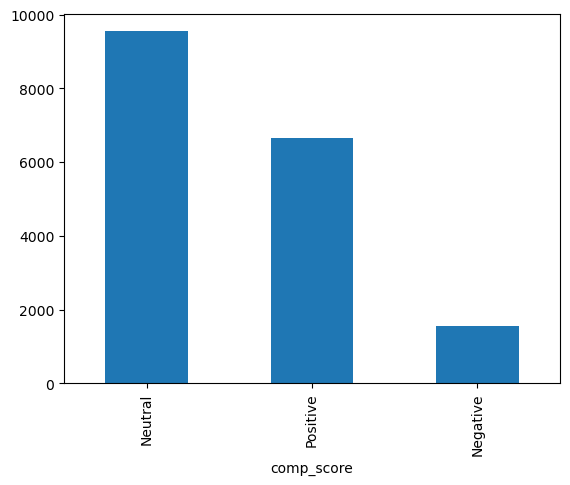

In [42]:
# let's see the distribution of negative and positive comments
message_df['comp_score'].value_counts().plot.bar();

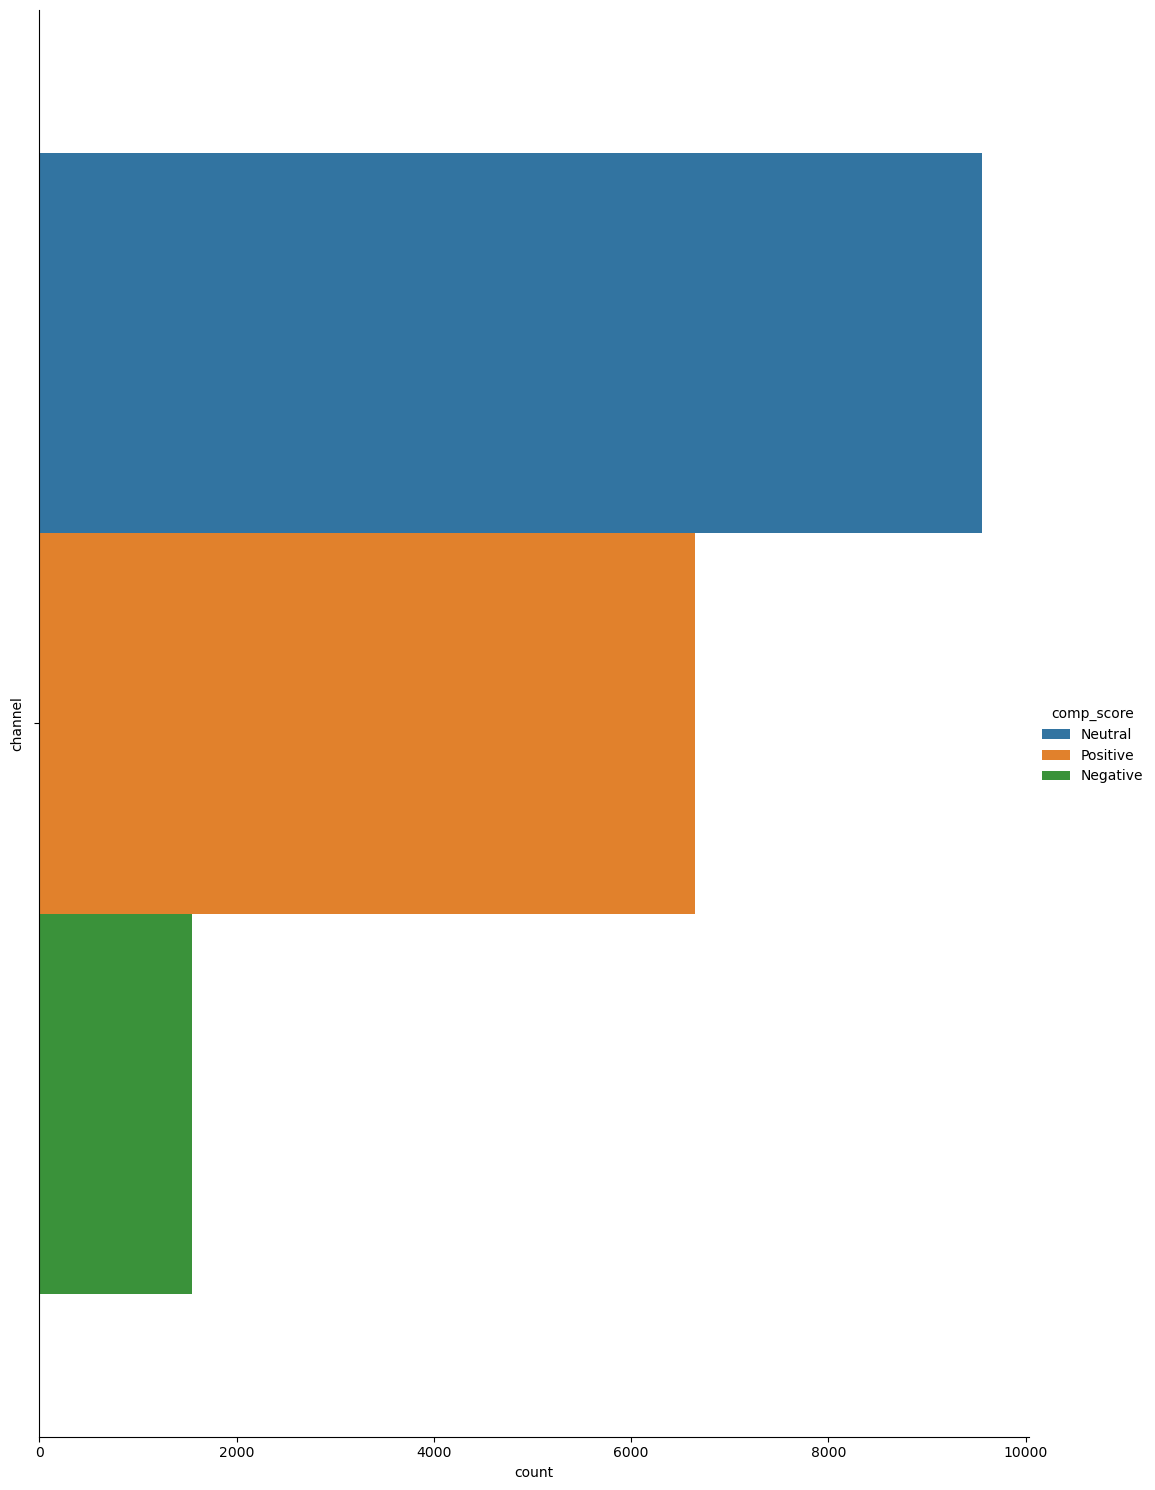

In [43]:
# sentiment ditribution between channels

# channels sentiment distribution
g = sns.catplot(y = 'channel', hue = 'comp_score', 
                data = message_df, kind="count",
                height=15, aspect=.7);

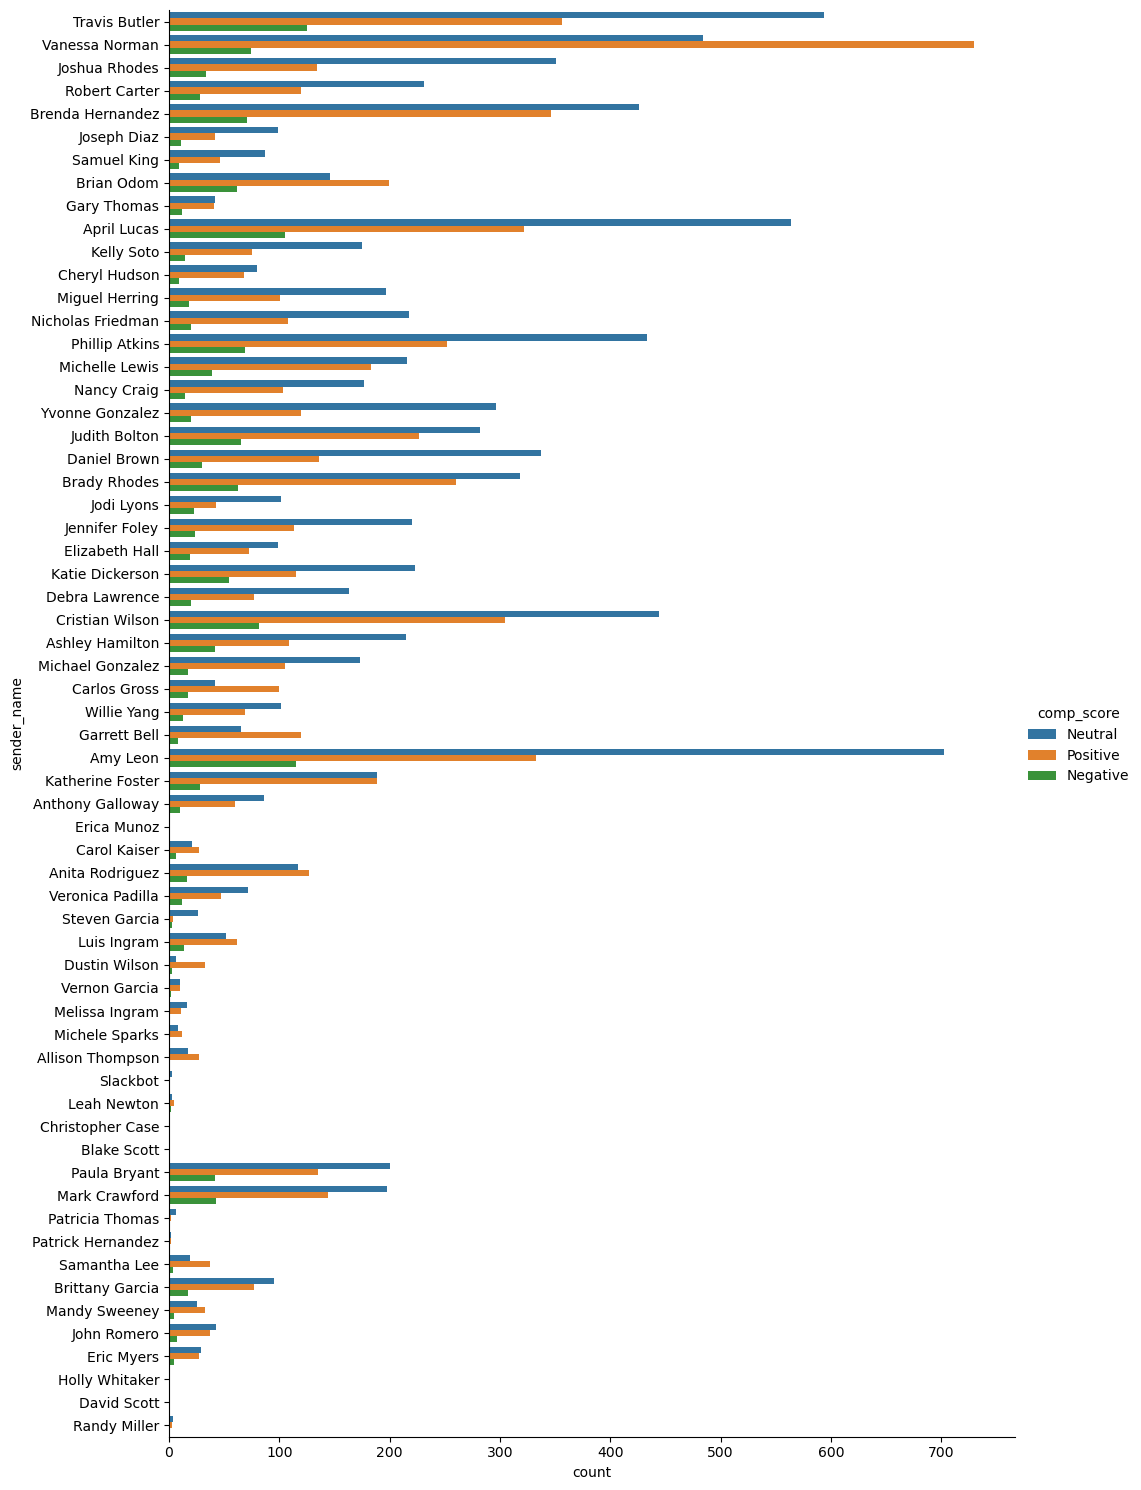

In [44]:
# individuals sentiment distribution 
g = sns.catplot(y = 'sender_name', hue = 'comp_score',
                data=message_df, kind="count",
                height=15, aspect=.7);

#### Wordcloud

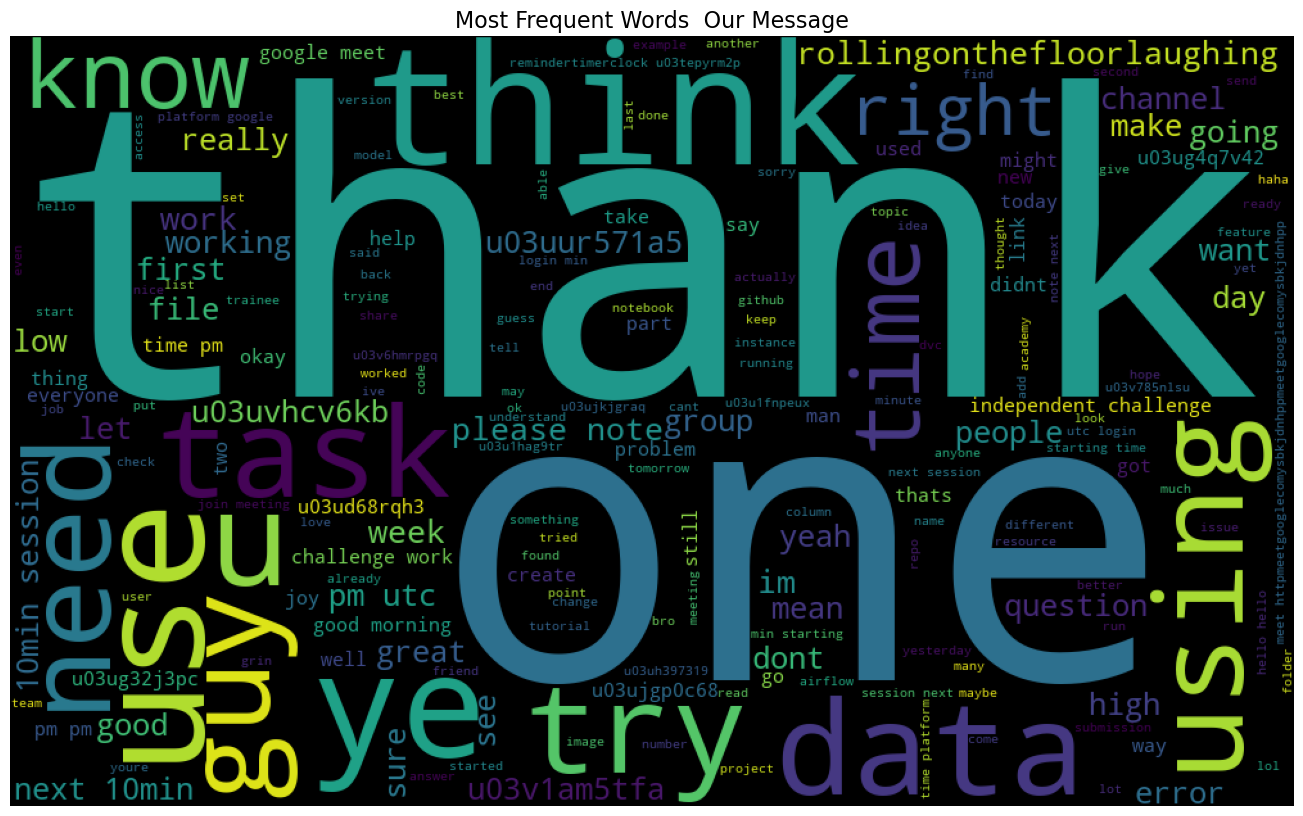

In [45]:
plt.figure(figsize=(20, 10))
plt.imshow(WordCloud(width=1000,height=600,stopwords=STOPWORDS).generate(' '.join(message_df.msg_content.values)))
plt.axis('off')
plt.title('Most Frequent Words  Our Message',fontsize=16)
plt.show()

# **Model Analysis**

Perplexity is also a measure of model quality and in natural language processing is often used as “perplexity per number of words”. It describes how well a model predicts a sample, i.e. how much it is “perplexed” by a sample from the observed data. The lower the score, the better the model for the given data.

A coherence matrix is used to test the model for accuracy. Topic coherence is a measure that compares different topic models based on their human-interpretability. The coherence score ‘C_V’ provides a numerical value to the interpretability of the topics

In [46]:
# Compute Perplexity

#It's a measure of how good the model is. The lower the better. Perplexity is a negative value
print('\nPerplexity: ', lda_model.log_perplexity(corpus))
doc_lda = lda_model[corpus]


# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=word_list, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\n Lda model Coherence Score/Accuracy on slack: ', coherence_lda)


Perplexity:  -9.31055142333484

 Lda model Coherence Score/Accuracy on slack:  0.35656643345274597


Basic Ldamodel Coherence Score  0.34 This means that the model has performed bad in topic modeling.

**Anlayizing results**
Exploring the Intertopic Distance Plot can help you learn about how topics relate to each other, including potential higher-level structure between groups of topics

In [47]:
import pyLDAvis.gensim_models as gensimvis
import pickle
import pyLDAvis
# Visualize the topics
pyLDAvis.enable_notebook()

LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word)
LDAvis_prepared

ModuleNotFoundError: No module named 'pyLDAvis'

## Building a Sentiment Classifier using Scikit-Learn

<center><img src="https://raw.githubusercontent.com/lazuxd/simple-imdb-sentiment-analysis/master/smiley.jpg"/></center>
<center><i>Image by AbsolutVision @ <a href="https://pixabay.com/ro/photos/smiley-emoticon-furie-sup%C4%83rat-2979107/">pixabay.com</a></i></center>

> &nbsp;&nbsp;&nbsp;&nbsp;**Sentiment analysis**, an important area in Natural Language Processing, is the process of automatically detecting affective states of text. Sentiment analysis is widely applied to voice-of-customer materials such as product reviews in online shopping websites like Amazon, movie reviews or social media. It can be just a basic task of classifying the polarity of a text as being positive/negative or it can go beyond polarity, looking at emotional states such as "happy", "angry", etc.

In [48]:
import numpy as np
import pandas as pd
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [49]:
PrepareData_obj=PrepareData(mesage_df)
message_df,word_list ,id2word,corpus, dtm, idffeatures=PrepareData_obj.preprocess_data()


In [50]:
message_df.head()

,msg_type,msg_content,sender_name,msg_sent_time,msg_dist_type,time_thread_start,reply_count,reply_users_count,reply_users,tm_thread_end,channel,scores,compound,comp_score
0,message,decent fellow big ups brother,Travis Butler,2022-10-05 12:07:13,text,2022-10-05 10:23:18,0,0,0,0,,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,Neutral
1,message,community building session remindertimerclock ...,Vanessa Norman,2022-10-05 14:50:01,text,0,0,0,0,0,,"{'neg': 0.0, 'neu': 0.772, 'pos': 0.228, 'comp...",0.7096,Positive
2,message,kahoot againsmirk,Joshua Rhodes,2022-10-05 14:51:09,text,2022-10-05 14:51:09,2,2,"U03V1AM5TFA,U03U1FNPEUX",2022-10-05 14:52:15,,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,Neutral
3,message,soon soon miss hahahah,Vanessa Norman,2022-10-05 14:51:45,text,2022-10-05 14:51:09,0,0,0,0,,"{'neg': 0.348, 'neu': 0.652, 'pos': 0.0, 'comp...",-0.1531,Negative
4,message,yess,Joshua Rhodes,2022-10-05 14:52:15,text,2022-10-05 14:51:09,0,0,0,0,,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,Neutral


In [51]:

labeled_df = message_df[['msg_content','comp_score' ]]

In [52]:
labeled_df

,msg_content,comp_score
0,decent fellow big ups brother,Neutral
1,community building session remindertimerclock ...,Positive
2,kahoot againsmirk,Neutral
3,soon soon miss hahahah,Negative
4,yess,Neutral
...,...,...
58,going submission today expecting link google c...,Neutral
59,thank,Positive
60,document uploaded yet structure submissions,Neutral
0,get trainees optedin given asset print status ...,Positive


### Basic EDA

<Axes: ylabel='count'>

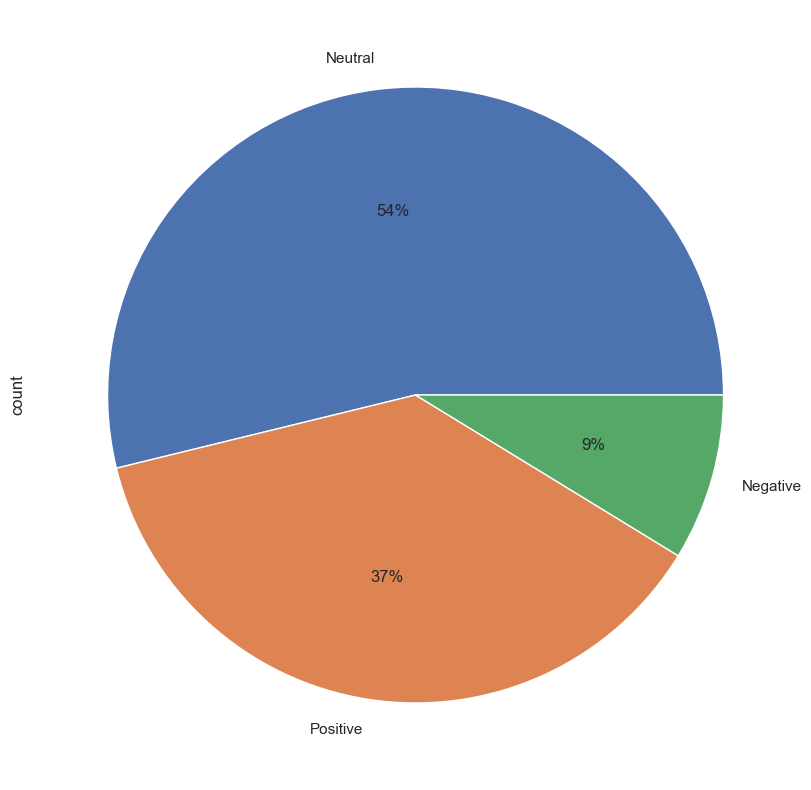

In [53]:
# Distribution of sentiments across all the tweets
sns.set(rc={'figure.figsize':(14,10)})
labeled_df.comp_score.value_counts().plot(kind='pie', autopct='%1.0f%%')

### Finetuning pretraiend huggingface models

In [54]:
# !pip install -q transformers
# !pip install wandb
# !pip install emoji==0.6.0

In [55]:
labeled_df.head()

,msg_content,comp_score
0,decent fellow big ups brother,Neutral
1,community building session remindertimerclock ...,Positive
2,kahoot againsmirk,Neutral
3,soon soon miss hahahah,Negative
4,yess,Neutral


In [56]:
# filter positive and negative sentiments only
df = labeled_df[(labeled_df.comp_score == 'Positive') | (labeled_df.comp_score == 'Negative')]
target_map = { 'Positive': 1, 'Negative': 0}
df['target'] = df['comp_score'].map(target_map)
### select tweets only
texts = df['msg_content'].to_list()
labels = df['target'].to_list()

In [57]:
# import required liabraries
from transformers import pipeline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split

None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


In [59]:
!pip install tensorflow


  Obtaining dependency information for tensorflow from https://files.pythonhosted.org/packages/85/15/cf99a373812d37f8ae99752a34a9f5f690d820ceb5b302e922705bc18944/tensorflow-2.15.0-cp311-cp311-macosx_12_0_arm64.whl.metadata
  Obtaining dependency information for tensorflow-macos==2.15.0 from https://files.pythonhosted.org/packages/eb/9f/0759e2fea4a3c48f070b64811c2c57036b46353ba87263afc810b8f4188a/tensorflow_macos-2.15.0-cp311-cp311-macosx_12_0_arm64.whl.metadata
  Obtaining dependency information for absl-py>=1.0.0 from https://files.pythonhosted.org/packages/01/e4/dc0a1dcc4e74e08d7abedab278c795eef54a224363bb18f5692f416d834f/absl_py-2.0.0-py3-none-any.whl.metadata
  Obtaining dependency information for flatbuffers>=23.5.26 from https://files.pythonhosted.org/packages/6f/12/d5c79ee252793ffe845d58a913197bfa02ae9a0b5c9bc3dc4b58d477b9e7/flatbuffers-23.5.26-py2.py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 383.6 kB/s eta 0:00:00a 0:00:01
  Obtaining depe

  Obtaining dependency information for tensorboard-data-server<0.8.0,>=0.7.0 from https://files.pythonhosted.org/packages/7a/13/e503968fefabd4c6b2650af21e110aa8466fe21432cd7c43a84577a89438/tensorboard_data_server-0.7.2-py3-none-any.whl.metadata
  Obtaining dependency information for cachetools<6.0,>=2.0.0 from https://files.pythonhosted.org/packages/a2/91/2d843adb9fbd911e0da45fbf6f18ca89d07a087c3daa23e955584f90ebf4/cachetools-5.3.2-py3-none-any.whl.metadata
  Using cached cachetools-5.3.2-py3-none-any.whl.metadata (5.2 kB)
  Using cached rsa-4.9-py3-none-any.whl (34 kB)
  Using cached requests_oauthlib-1.3.1-py2.py3-none-any.whl (23 kB)
  Using cached oauthlib-3.2.2-py3-none-any.whl (151 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 208.8/208.8 MB 232.6 kB/s eta 0:00:0000:0100:20
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 152.5 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 108.7 kB/s eta 0:00:0000:0100:03
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [58]:
# create pipeline for sentiment analysis
classification = pipeline('sentiment-analysis')
type(classification)

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


RuntimeError: At least one of TensorFlow 2.0 or PyTorch should be installed. To install TensorFlow 2.0, read the instructions at https://www.tensorflow.org/install/ To install PyTorch, read the instructions at https://pytorch.org/.

In [60]:
!pip install torch


  Obtaining dependency information for torch from https://files.pythonhosted.org/packages/5b/46/3def5bdaae03c21a7662673e6bda1f60a046afce48e0d6319ce4542bca31/torch-2.1.1-cp311-none-macosx_11_0_arm64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.6/59.6 MB 127.3 kB/s eta 0:00:0000:0100:12


In [ ]:
predictions = classification(texts)

In [ ]:
probs = [d['score'] if d['label'].startswith('P') else 1 - d['score'] for d in predictions ]
preds = [1 if d['label'].startswith('P') else 0 for d in predictions]
# convert into numpy array
preds = np.array(preds)

Evaluation

In [ ]:
# calculate confusion matrix
cm = confusion_matrix(df['target'], preds)
# create function for plotting confusion matrix
def plot_cm(cm):
  classes = ['negative','positive']
  df_cm = pd.DataFrame(cm, index=classes, columns=classes)
  ax = sns.heatmap(df_cm, annot = True, fmt='g')
  ax.set_xlabel('Predicted')
  ax.set_ylabel('Actual')

plot_cm(cm)

In [ ]:
import wandb
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline


In [ ]:
wandb.init(project="sentiment-analysis")

In [ ]:
import wandb
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
wandb.init(project="sentiment-analysis")
model = AutoModelForSequenceClassification.from_pretrained("finiteautomata/bertweet-base-sentiment-analysis")
tokenizer = AutoTokenizer.from_pretrained("finiteautomata/bertweet-base-sentiment-analysis")
classifier = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)
results = classifier(texts)
wandb.log({"predictions": results})

In [ ]:
def calculate_accuracy(predictions, true_labels):
    predicted_labels = []

    for prediction in predictions:
        if prediction['label'] == 'NEG':
            predicted_labels.append(0)
        elif prediction['label'] == 'POS':
            predicted_labels.append(1)


    correct_predictions = sum(p == t for p, t in zip(predicted_labels, true_labels))
    total_predictions = len(true_labels)

    accuracy = correct_predictions / total_predictions
    return accuracy

In [ ]:
# Initialize wandb
wandb.init(project="sentiment-analysis")

# Load model and tokenizer
model = AutoModelForSequenceClassification.from_pretrained("finiteautomata/bertweet-base-sentiment-analysis")
tokenizer = AutoTokenizer.from_pretrained("finiteautomata/bertweet-base-sentiment-analysis")

# Watch the model to log its parameters
wandb.watch(model, log="all")

# Setup sentiment analysis pipeline
classifier = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

# Perform sentiment analysis
results = classifier(texts)

# Log results
wandb.log({"predictions": results})


accuracy = calculate_accuracy(results, labels)
wandb.log({"accuracy": accuracy})

# Finish the run
wandb.finish()
